# Convolutional Neural Network

A convolutional neural network (CNN) is a a specific type of neural net that can be used to process data with a known, grid-like topology (e.g. 2D grid of pixel values). CNNs got popular due to their excellent performance in image recognition tasks. In this notebook, we will use a basic CNN to classify the MNIST dataset.

In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mnist import MNIST
import tensorflow as tf

warnings.simplefilter('ignore')
% matplotlib inline

## MNIST dataset

The MNIST dataset contains handwritten digits and is available [here](http://yann.lecun.com/exdb/mnist/). To proceed you first have to download the training data and labels and the test data and labels. Next, unpack them into a folder named "mnist" in your home directory. To make the data extraction work, you will have to rename the dots to -, for example t10k-images.idx3-ubyte must be renamed to t10k-images-idx3-ubyte.

To read the MNIST files we will use the [python mnist package](https://pypi.org/project/python-mnist/). You can install the package via

```bash
pip install python-mnist
```

Note: another convenient way to download and handle the MNIST dataset is explained in the [VAE notebook](basic_variational_autoencoder.ipynb) and involves a tensorflow convience function.

In [3]:
path_to_data = os.path.expanduser("~/mnist/")
mnist = MNIST(path_to_data)

x_train, y_train = mnist.load_training()
x_test, y_test = mnist.load_testing()

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

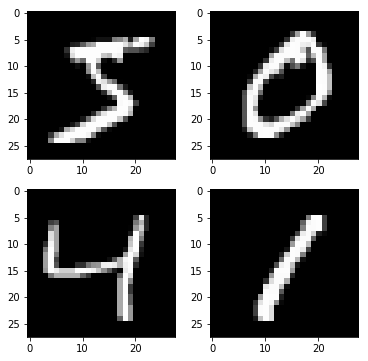

In [4]:
fig = plt.figure(figsize=(6,6))

for i in range(4):
    ax = fig.add_subplot(2, 2, i + 1)
    ax.imshow(np.reshape(x_train[i], (28, 28)), cmap='gray')

## Creating one-hot encoded labels

In [7]:
n_train_samples = x_train.shape[0]
n_test_samples = x_test.shape[0]
n_classes = 10

y_train_one_hot = np.zeros((n_train_samples, n_classes))
y_train_one_hot[np.arange(n_train_samples), y_train] = 1

y_test_one_hot = np.zeros((n_test_samples, n_classes))
y_test_one_hot[np.arange(n_test_samples), y_test] = 1

print(f"Training set shape: {x_train.shape}")
print(f"Training labels shape: {y_train_one_hot.shape}")

print(f"Test set shape: {x_test.shape}")
print(f"Test set shape: {y_test_one_hot.shape}")

Training set shape: (60000, 784)
Training labels shape: (60000, 10)
Test set shape: (10000, 784)
Test set shape: (10000, 10)


## CNN layers

A convolutional neural network consists of a stack of layers. The most important layer types are: convolutional layer, pooling layer and fully connected layer. Typically, convolutional and pooling layers are used in an alternating fashion throughout the CNN. The final, fully connected layer is used to classify the extracted feature values into distinct classes.

### Convolutional layer:

A convolutional layer is a specific type of neural network layer that performs *convolutions* on an input image. The convolutions are performed by applying a certain number of convolutional filters (also called kernels) to the image. These filters are able to extract features from the input image (e.g. edges or lines). For each input region the kernel is applied to, a single value in the output feature map is produced. 

Detailed information about the functioning of convolutional layers and several illustrations can be found in the lecture notes of the [Stanford class on CNN's](http://cs231n.github.io/convolutional-networks/).


**Output shape of a convolutional layer:**   
To compute the output shape of a conv layer you need to know how a convolutional layer is structured. In summary (see Stanford class for details):

A convolutional layer:
- Accepts an input tensor of shape $W_1 \times H_1 \times D_1$ (width, height, depth)
    - The depth describes the number of color channels. For example, for MNIST we have only 1 color channel (grayscale). Most images will be in RGB mode with 3 color channels (red, blue, green)
     
- Requires four hyperparameters:
    - the number of filters $K$
    - the shape / spacial extend of the filters $F$
    - the stride $S$
    - the amount of zero padding $P$   
    common settings for padding are 'same' and 'valid'. 'same' means that the input will be padded with enough zeros to ensure that the output will have the same widht and height as the input. 'valid' means that no padding is used
     
- Produces an output tensor of shape  $W_2 \times H_2 \times D_2$
    These shapes can be computed as follows:   
    $W_2 = \frac{W_1 - F + 2P}{S} + 1$   
       
    $H_2 = \frac{H_1 - F + 2P}{S} + 1$
   
    $D_2 = K$


**Example:**

For MNIST, the input has shape $28 \times 28 \times 1$. In the first convolutional layer we will use $32$ filters with a kernel size of $5 
\times 5$. We will use "same" padding and a stride of $1$.

Therefore, the output of the first convolutional layer will have the following shape: 

$W_2 = \frac{28 - 5 + 2 * 0}{1} + 1 = 24$   
       
$H_2 = \frac{28 - 5 + 2 * 0}{1} + 1 = 24$
   
$D_2 = K = 1$
   
      
      

### Pooling layer:

Pooling layers are used to reduce the dimensionality of the feature maps produced by convolutional layers. A pooling function replaces the output of a convolutional layer at a certain location with a summary statistic of the nearby outputs. For example, *max pooling* computes the *maximum* output value within a rectangular neighborhood.

**Example**:

![title](figures/max_pool.png)


### Fully connected layer:

The fully connected layers are used to classify the features extracted by the convolutional and pooling layers. 

## CNN network architecture

In [9]:
# Network parameters
height = width = 28
n_channels = 1
batch_size = 100
lr = 0.001
n_epochs = 5

n_train_batches = n_train_samples // batch_size
n_test_batches = n_test_samples // batch_size

In [10]:
# Placeholders for input batches and targets
X_placeholder = tf.placeholder(tf.float32, [None, height * width])
y_placeholder = tf.placeholder(tf.float32, [None, n_classes])
training = tf.placeholder(tf.bool)

input_layer = tf.reshape(X_placeholder, shape=[-1, height, width, n_channels])

# First convolutional layer
# output shape: (batch_size, 28, 28, 32)
conv1 = tf.layers.conv2d(
            inputs=input_layer,
            filters=32,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)

# First pooling layer
# output shape: (batch_size, 14, 14, 32)
pool1 = tf.layers.max_pooling2d(
            inputs=conv1,
            pool_size=[2, 2],
            strides=2)

# Second convolutional layer
# output shape: (batch_size, 14, 14, 64)    
conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=64,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)

# Second pooling layer 
# output shape: (batch_size, 7, 7, 64)    
pool2 = tf.layers.max_pooling2d(
            inputs=conv2,
            pool_size=[2, 2],
            strides=2)

# We need to reshape the output of pool2 to fit the fully connected layer
pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

# Fully connected layer    
fully_connected = tf.layers.dense(
                    inputs=pool2_flat,
                    units=1024,
                    activation=tf.nn.relu)

# Dropout layer for regularization
dropout = tf.layers.dropout(
            inputs=fully_connected,
            rate=0.4,
            training=training)

# Logits (unnormalized probabilities)
logits = tf.layers.dense(
            inputs=dropout,
            units=n_classes)

# Loss function
loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                            logits=logits,
                            labels=y_placeholder))

# Optimizer and train step
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y_placeholder,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Training and Testing

In [11]:
with tf.Session() as sess:
    
    # We first have to initialize all variables
    init = tf.global_variables_initializer()
    sess.run(init)
        
    # TRAINING
    for epoch in range(n_epochs):
        
        print()
        print(f"Epoch: {epoch}")
        
        for i in range(n_train_batches):           
            start = i * batch_size
            end = (i + 1) * batch_size

            x_batch = x_train[start:end]        
            y_batch = y_train_one_hot[start:end]
            
            
            _train_step, _loss = sess.run([train_step, loss],
                                        feed_dict=
                                        {X_placeholder:x_batch,
                                         y_placeholder:y_batch,
                                         training: True
                                        })
    
            
            if i % 100 == 0:
                _loss, _accuracy = sess.run([loss, accuracy],
                                 feed_dict={
                                     X_placeholder:x_batch,
                                     y_placeholder:y_batch,
                                     training: True
                                 })
                
                print(f"Minibatch loss: {_loss:.3f}   " 
                      f"Accuracy: {_accuracy:.3f}")
          
    print()
    print(f"Optimization done! Let's calculate the test error")
      
    # TESTING
    losses = []
    acc = []

    for i in range(n_test_batches):

        start = i * batch_size
        end = (i + 1) * batch_size

        x_test_batch = x_test[start:end]        
        y_test_batch = y_test_one_hot[start:end]


        test_loss, test_accuracy = sess.run(
                                        [loss, accuracy],
                                        feed_dict={
                                                X_placeholder:x_test_batch,
                                                y_placeholder:y_test_batch,
                                                training: False
                                                })

        losses.append(test_loss)
        acc.append(test_accuracy)

    print()
    print(f"Average loss on test set: {np.mean(losses):.3f}")
    print(f"Accuracy on test set: {np.mean(acc):.3f}")


Epoch: 0
Minibatch loss: 80.091   Accuracy: 0.230
Minibatch loss: 0.200   Accuracy: 0.950
Minibatch loss: 0.163   Accuracy: 0.930
Minibatch loss: 0.219   Accuracy: 0.940
Minibatch loss: 0.083   Accuracy: 0.970
Minibatch loss: 0.051   Accuracy: 0.990

Epoch: 1
Minibatch loss: 0.074   Accuracy: 0.990
Minibatch loss: 0.017   Accuracy: 1.000
Minibatch loss: 0.125   Accuracy: 0.960
Minibatch loss: 0.127   Accuracy: 0.970
Minibatch loss: 0.029   Accuracy: 1.000
Minibatch loss: 0.033   Accuracy: 0.990

Epoch: 2
Minibatch loss: 0.017   Accuracy: 1.000
Minibatch loss: 0.011   Accuracy: 1.000
Minibatch loss: 0.081   Accuracy: 0.970
Minibatch loss: 0.027   Accuracy: 1.000
Minibatch loss: 0.068   Accuracy: 0.980
Minibatch loss: 0.011   Accuracy: 0.990

Epoch: 3
Minibatch loss: 0.031   Accuracy: 0.980
Minibatch loss: 0.034   Accuracy: 0.980
Minibatch loss: 0.048   Accuracy: 0.980
Minibatch loss: 0.066   Accuracy: 0.980
Minibatch loss: 0.006   Accuracy: 1.000
Minibatch loss: 0.011   Accuracy: 1.000